In [ ]:
import pandas as pd
import numpy as np
import nltk
nltk.download('all')
import warnings
# To ignore all warnings
warnings.filterwarnings("ignore")

In [92]:
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.stem.wordnet import WordNetLemmatizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from sklearn.model_selection import train_test_split
import glob, os
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Embedding, Dense,Flatten,Dropout,BatchNormalization
from tensorflow.keras import regularizers

import numpy as np
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer

In [93]:
train_df=pd.read_csv("train_df.csv")
train_df[['tweet', 'sentiment']]

,tweet,sentiment
0,"I know I missed something here , but what does...",negative
1,What do you think of Beside Ourselves as a tit...,neutral
2,:D I intend to be one someday .,positive
3,LLLINKKK LLLINKKK IIIMAGEEELLLINKKK The choice...,negative
4,LLLINKKK Some more mountains .,neutral
...,...,...
53363,@Racalto_SK ok good to know. Punting at MetLif...,positive
53364,everyone who sat around me at metlife was so a...,neutral
53365,what giants or niners fans would wanna go to t...,neutral
53366,Anybody want a ticket for tomorrow Colombia vs...,positive


In [94]:
test_df=pd.read_csv("test_df.csv")
test_df[['tweet', 'sentiment']]

,tweet,sentiment
0,#ArianaGrande Ari By Ariana Grande 80% Full ht...,neutral
1,Ariana Grande KIIS FM Yours Truly CD listening...,positive
2,Ariana Grande White House Easter Egg Roll in W...,positive
3,#CD #Musics Ariana Grande Sweet Like Candy 3.4...,positive
4,SIDE TO SIDE 😘 @arianagrande #sidetoside #aria...,neutral
...,...,...
11901,@dansen17 update: Zac Efron kissing a puppy ht...,positive
11902,#zac efron sex pic skins michelle sex https://...,neutral
11903,First Look at Neighbors 2 with Zac Efron Shirt...,neutral
11904,zac efron poses nude #lovely libra porn https:...,neutral


### convert categorical sentiment labels ("positive," "neutral," and "negative") into numerical values (2, 1, and 0)

In [95]:
#preparing train lables
train_df.loc[train_df.sentiment == "positive", "sentiment"] = 2
train_df.loc[train_df.sentiment == "neutral", "sentiment"] = 1
train_df.loc[train_df.sentiment == "negative", "sentiment"] = 0

labels = train_df["sentiment"].tolist()
labels = [ int(x) for x in labels ]

#preparing test labels
test_df.loc[test_df.sentiment == "positive", "sentiment"] = 2
test_df.loc[test_df.sentiment == "neutral", "sentiment"] = 1
test_df.loc[test_df.sentiment == "negative", "sentiment"] = 0

labels_test = test_df["sentiment"].tolist()
labels_test = [ int(x) for x in labels_test ]

### Converting tweets and labels into lists.

In [96]:
train_tweets = train_df.tweet.values
y_train_orig = train_df.sentiment.values
test_tweets = test_df.tweet.values
y_test_orig = test_df.sentiment.values

In [97]:
y_test_orig

array([1, 2, 2, ..., 1, 1, 1], dtype=object)

### Helper methods for cleaning tweets.

In [98]:
!pip install contractions

In [99]:
import nltk

In [100]:
from keras.utils import to_categorical
import re
import string
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import contractions

# Function to remove URLs from the text
def remove_urls(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'', text)

# Function to remove HTML tags from the text
def remove_html(text):
    html = re.compile(r'<.*?>')
    return html.sub(r'', text)

# Function to split the text into a list of words
def split_text(text):
    text = text.split()
    return text

# Function to convert text to lowercase
def lower(text):
    text = [word.lower() for word in text]
    return str(text)

# Function to remove punctuation and numbers from the text
def remove_punct(text):
    text = ''.join([char for char in text if char not in string.punctuation])
    text = re.sub('[0-9]+', '', str(text))
    return text

# Function to remove stopwords from the text
def remove_stopwords(text):
    pattern = re.compile(r'\b(' + r'|'.join(stopwords.words('english')) + r')\b\s*')
    text = pattern.sub(' ', text)
    return text

# Create a WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

# Function to lemmatize words in the text
def lemmatize_words(text):
    text = lemmatizer.lemmatize(text)
    return text

# Main function to clean a tweet by applying all the above preprocessing steps
def clean_tweet(text):
    t0 = remove_urls(text)
    t1 = remove_html(t0)
    t2 = split_text(t1)
    t3 = lower(t2)
    t4 = remove_punct(t3)
    t5 = remove_stopwords(t4)
    t6 = lemmatize_words(t5)

    # Expand contractions (e.g., "I'll" to "I will")
    t6 = contractions.fix(t6)

    # Remove non-alphanumeric characters
    t6 = re.sub(r'[^a-zA-Z0-9]', ' ', t6)

    # Remove non-ASCII characters
    t6 = t6.encode("ascii", "ignore").decode()

    # Remove extra white spaces
    t6 = re.sub(r'\s+', ' ', t6).strip()

    return t6

# Apply advanced cleaning to training tweets
clean_training_tweets = []
for i in range(len(train_tweets)):
    data = clean_tweet(train_tweets[i])
    clean_training_tweets.append(data)

# Apply advanced cleaning to testing tweets
clean_testing_tweets = []
for i in range(len(test_tweets)):
    data = clean_tweet(test_tweets[i])
    clean_testing_tweets.append(data)

# Example of using to_categorical
train_labels = to_categorical(y_train_orig)



In [ ]:
from keras.utils import to_categorical

train_labels = to_categorical(y_train_orig)

clean_training_tweets = []
for i in range(len(train_tweets)):
    data = clean_tweet(train_tweets[i])
    clean_training_tweets.append(data)

clean_testing_tweets = []
for i in range(len(test_tweets)):
    data = clean_tweet(test_tweets[i])
    clean_testing_tweets.append(data)

### Checking the tweets after cleaning them.

In [104]:
print(clean_training_tweets[:10])
print(clean_testing_tweets[:10])

['know missed something thud mean', 'think beside title', 'intend one someday', 'lllinkkk lllinkkk iiimageeelllinkkk choice take rocky put death row', 'lllinkkk mountains', 'still yo friend grrrrl', 'wait ill dress love', 'snakiest people face planet', 'villains wager', 'could taken pic wo looking dead face']

['arianagrande ari ariana grande full singer actress', 'ariana grande kiis fm truly cd listening party burbank arianagrande', 'ariana grande white house easter egg roll washington arianagrande', 'cd musics ariana grande sweet like candy oz ml sealed box authenic new', 'side side arianagrande sidetoside arianagrande musically comunidadgay lgbt lotb', 'hairspray live previews macys thanksgiving day parade arianagrande televisionnbc', 'lindsaylohan feeling thankful blasting arianagrande wearing toomuch', 'hate love songs dammit arianagrande', 'ariana grande right ft big sean arianagrande', 'one would prefer listen whole day could never choose arianagrande intoyou sidetoside songs po

In [15]:
from nltk.tokenize import word_tokenize
from gensim.models import Word2Vec
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import gensim
from gensim.models import Word2Vec

In [16]:
print('Loading word vectors...')
word2vec = {}
with open(os.path.join('/content/glove.6B.100d.txt'), encoding = "utf-8") as f:
    for line in f:
        values = line.split()
        word = values[0]
        vec = np.asarray(values[1:], dtype='float32')
        word2vec[word] = vec
print('Found %s word vectors.' % len(word2vec))

Loading word vectors...

Found 115834 word vectors.


In [17]:
tokenizer = Tokenizer(num_words= 20000, oov_token= 'OOV')
tokenizer.fit_on_texts(clean_training_tweets)
train_tweet_sequences = tokenizer.texts_to_sequences(clean_training_tweets)
word_index_train = tokenizer.word_index
print('Found %s unique words in train tweets.' % len(word_index_train))
X_train = pad_sequences(sequences=train_tweet_sequences, maxlen=50, padding= 'post')
test_tweet_sequences = tokenizer.texts_to_sequences(clean_testing_tweets)
X_test = pad_sequences(sequences= test_tweet_sequences, maxlen=50, padding='post')

Found 67019 unique words in train tweets.


In [18]:
num_words = min(20000, len(word_index_train)+1)
embedding_matrix = np.zeros((num_words, 100))

embeddings = []
for word, i in word_index_train.items():
    if i<20000:
        embeddings = word2vec.get(word)
        if embeddings is not None:
            embedding_matrix[i] = embeddings

In [21]:
model = Sequential()
model.add(Embedding(input_dim=20000,output_dim = 100, input_length=50))
model.add(LSTM(128,activation='relu',return_sequences=True))
model.add(Dense(100, activation="relu"))
model.add(Dense(100, activation="relu"))
model.add(Dense(50, activation="relu",kernel_regularizer='l1'))
model.add(Dropout(0.3))
model.add(BatchNormalization())
model.add(Flatten())
model.add(Dense(3, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [22]:
model.summary()

Model: "sequential_1"

_________________________________________________________________

 Layer (type)                Output Shape              Param #   


 embedding_1 (Embedding)     (None, 50, 100)           2000000   

                                                                 

 lstm_1 (LSTM)               (None, 50, 128)           117248    

                                                                 

 dense_4 (Dense)             (None, 50, 100)           12900     

                                                                 

 dense_5 (Dense)             (None, 50, 100)           10100     

                                                                 

 dense_6 (Dense)             (None, 50, 50)            5050      

                                                                 

 dropout_1 (Dropout)         (None, 50, 50)            0         

                                                                 

 batch_normalization_1 (Bat  (None, 50

In [23]:
model.fit(X_train, train_labels, epochs=8, batch_size=32)


Epoch 1/8

1668/1668 [==============================] - 217s 128ms/step - loss: 1.0961 - accuracy: 0.6018

Epoch 2/8

1668/1668 [==============================] - 207s 124ms/step - loss: 0.6899 - accuracy: 0.7035

Epoch 3/8

1668/1668 [==============================] - 208s 125ms/step - loss: 0.5988 - accuracy: 0.7701

Epoch 4/8

1668/1668 [==============================] - 214s 128ms/step - loss: 0.4478 - accuracy: 0.8225

Epoch 5/8

1668/1668 [==============================] - 209s 125ms/step - loss: 0.3457 - accuracy: 0.8669

Epoch 6/8

1668/1668 [==============================] - 210s 126ms/step - loss: 0.2661 - accuracy: 0.9001

Epoch 7/8

1668/1668 [==============================] - 217s 130ms/step - loss: 0.2085 - accuracy: 0.9247

Epoch 8/8

1668/1668 [==============================] - 220s 132ms/step - loss: 0.1662 - accuracy: 0.9422


In [24]:
pred_p = model.predict(X_test)

373/373 [==============================] - 13s 35ms/step


In [25]:
y_binary = to_categorical(labels_test)
model.evaluate(x = X_test, y =y_binary )

373/373 [==============================] - 14s 36ms/step - loss: 2.2613 - accuracy: 0.5326


[2.2613067626953125, 0.5325886011123657]

In [26]:
pred = (np.round(pred_p)).astype(int)
final_pred = []
for sample in pred:
    pred_label = sample.argmax()
    final_pred.append(pred_label)

In [27]:
from sklearn.metrics import classification_report
print(classification_report(labels_test, final_pred))

              precision    recall  f1-score   support



           0       0.50      0.62      0.55      3811

           1       0.60      0.47      0.52      5743

           2       0.47      0.53      0.50      2352



    accuracy                           0.53     11906

   macro avg       0.52      0.54      0.52     11906

weighted avg       0.54      0.53      0.53     11906




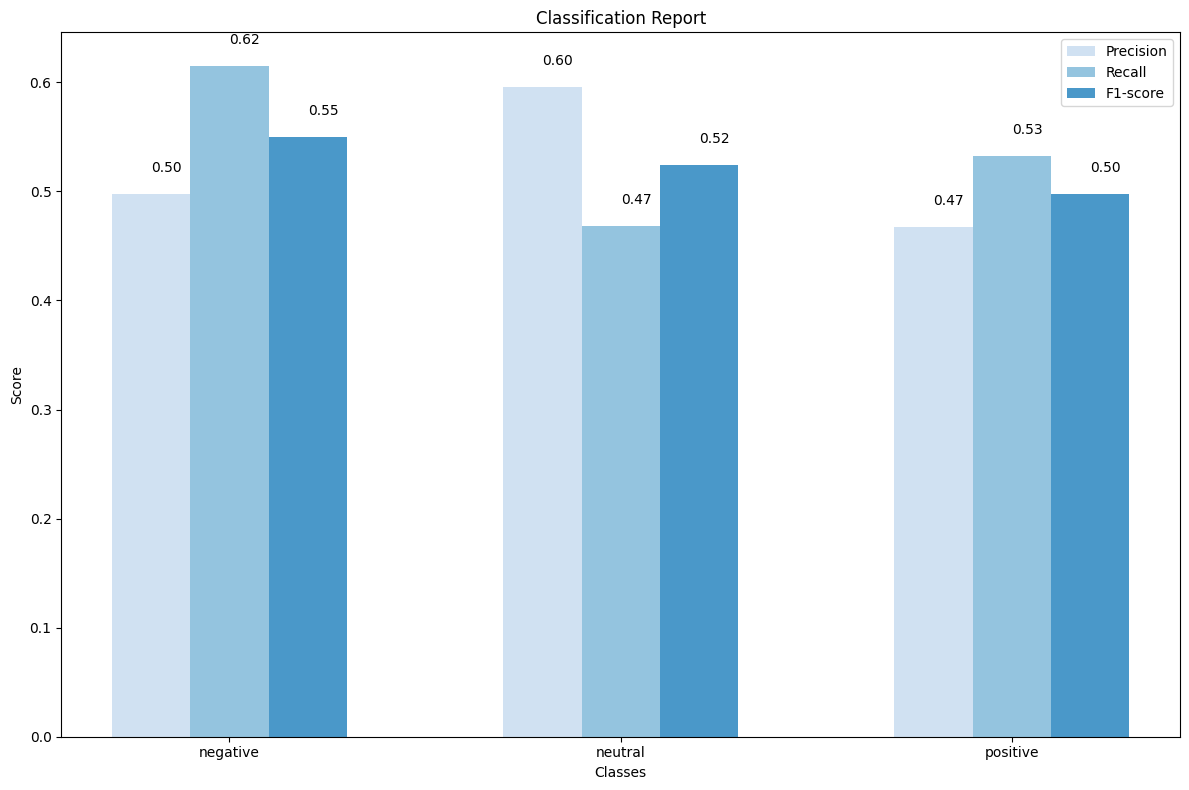

In [70]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report

# Generate classification report
report = classification_report(labels_test, final_pred, target_names=['negative', 'neutral', 'positive'], output_dict=True)

# Extract metrics and classes
metrics = list(report.keys())
classes = list(report.keys())[:-3]

# Extract metric values for each class
precision = [report[c]['precision'] for c in classes]
recall = [report[c]['recall'] for c in classes]
f1_score = [report[c]['f1-score'] for c in classes]
support = [report[c]['support'] for c in classes]

# Create a figure and axes
fig, ax = plt.subplots(figsize=(12, 8))

# Define color scheme
color_scheme = plt.cm.get_cmap('Blues')

# Plot precision, recall, and F1-score with blue color
x = np.arange(len(classes))
width = 0.2
ax.bar(x - width, precision, width, label='Precision', color=color_scheme(0.2))
ax.bar(x, recall, width, label='Recall', color=color_scheme(0.4))
ax.bar(x + width, f1_score, width, label='F1-score', color=color_scheme(0.6))

# Set labels and title
ax.set_xlabel('Classes')
ax.set_ylabel('Score')
ax.set_title('Classification Report')
ax.set_xticks(x)
ax.set_xticklabels(classes)
ax.legend()

# Add text labels to each bar
for i in range(len(classes)):
    ax.text(i - width, precision[i] + 0.02, f'{precision[i]:.2f}')
    ax.text(i, recall[i] + 0.02, f'{recall[i]:.2f}')
    ax.text(i + width, f1_score[i] + 0.02, f'{f1_score[i]:.2f}')

plt.tight_layout()
plt.show()

In [35]:
cm=confusion_matrix(labels_test,final_pred)
cm

array([[2344, 1126,  341],
       [1965, 2690, 1088],
       [ 401,  698, 1253]])

In [39]:
import matplotlib.pyplot as plt
import itertools

In [40]:
def plot_confusion_matrix(cm, classes,
                        normalize=False,
                        title='Confusion matrix',
                        cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="black" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization

[[2344 1126  341]

 [1965 2690 1088]

 [ 401  698 1253]]


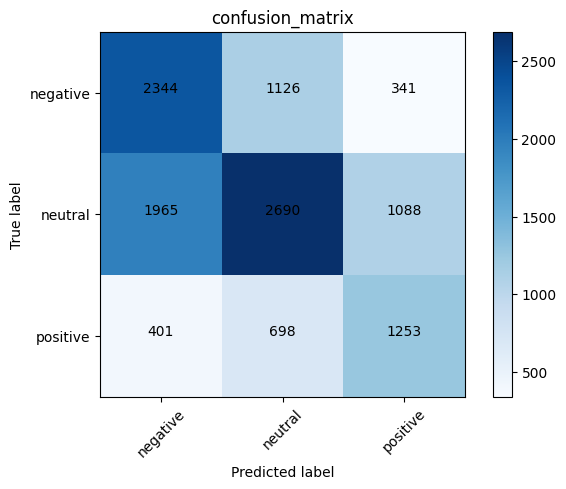

In [41]:
cm_plot_labels = ['negative', 'neutral', 'positive']
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='confusion_matrix')

In [56]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [57]:
model.save("/content/drive/MyDrive/model/LSTM.h5")

In [ ]:
import tensorflow as tf

# Load the Keras model
model = tf.keras.models.load_model('/content/drive/MyDrive/model/LSTM.h5')

# Convert the Keras model to TensorFlow Lite with selective TensorFlow ops
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS, tf.lite.OpsSet.SELECT_TF_OPS]
tflite_model = converter.convert()

# Save the TensorFlow Lite model to a .tflite file
with open('/content/drive/MyDrive/model.tflite', 'wb') as f:
    f.write(tflite_model)

In [58]:
from matplotlib import pyplot

In [59]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, Bidirectional
import os
import tensorflow as tf


In [60]:
print('Loading word vectors...')
word2vec = {}
with open(os.path.join('/content/glove.6B.100d.txt'), encoding = "utf-8") as f:
    for line in f:
        values = line.split()
        word = values[0]
        vec = np.asarray(values[1:], dtype='float32')
        word2vec[word] = vec
print('Found %s word vectors.' % len(word2vec))

Loading word vectors...

Found 115834 word vectors.


In [61]:
# converting tweets to integer sequences
tokenizer = Tokenizer(num_words= 20000, oov_token= 'OOV')
tokenizer.fit_on_texts(clean_training_tweets)
train_tweet_sequences = tokenizer.texts_to_sequences(clean_training_tweets)
word_index_train = tokenizer.word_index
print('Found %s unique words in train tweets.' % len(word_index_train))
X_train = pad_sequences(sequences=train_tweet_sequences, maxlen=32, padding= 'post')


test_tweet_sequences = tokenizer.texts_to_sequences(clean_testing_tweets)
X_test = pad_sequences(sequences= test_tweet_sequences, maxlen=32, padding='post')

Found 67019 unique words in train tweets.


In [62]:
num_words = min(20000, len(word_index_train)+1)
embedding_matrix = np.zeros((num_words, 100))

embeddings = []
for word, i in word_index_train.items():
    if i<20000:
        embeddings = word2vec.get(word)
        if embeddings is not None:
            embedding_matrix[i] = embeddings

In [63]:
y_binary = to_categorical(labels_test)

In [64]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(input_dim=num_words,output_dim = 100, weights=[embedding_matrix], input_length=32,trainable=False))
model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True)))
model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(100, return_sequences=True)))
model.add(tf.keras.layers.Dense(128, activation="relu"))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(3, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(), metrics=['accuracy'])

In [65]:
model.summary()

Model: "sequential_2"

_________________________________________________________________

 Layer (type)                Output Shape              Param #   


 embedding_2 (Embedding)     (None, 32, 100)           2000000   

                                                                 

 bidirectional (Bidirection  (None, 32, 256)           234496    

 al)                                                             

                                                                 

 bidirectional_1 (Bidirecti  (None, 32, 200)           285600    

 onal)                                                           

                                                                 

 dense_8 (Dense)             (None, 32, 128)           25728     

                                                                 

 dropout_2 (Dropout)         (None, 32, 128)           0         

                                                                 

 flatten_2 (Flatten)         (None, 40

In [69]:
model.fit(X_train, train_labels, epochs=10, batch_size=32)

Epoch 1/10

1668/1668 [==============================] - 373s 223ms/step - loss: 0.7854 - accuracy: 0.6389

Epoch 2/10

1668/1668 [==============================] - 370s 222ms/step - loss: 0.7401 - accuracy: 0.6645

Epoch 3/10

1668/1668 [==============================] - 387s 232ms/step - loss: 0.7029 - accuracy: 0.6836

Epoch 4/10

1668/1668 [==============================] - 379s 227ms/step - loss: 0.6600 - accuracy: 0.7087

Epoch 5/10

1668/1668 [==============================] - 374s 224ms/step - loss: 0.6070 - accuracy: 0.7320

Epoch 6/10

1668/1668 [==============================] - 382s 229ms/step - loss: 0.5418 - accuracy: 0.7648

Epoch 7/10

1668/1668 [==============================] - 383s 230ms/step - loss: 0.4651 - accuracy: 0.7995

Epoch 8/10

1668/1668 [==============================] - 400s 240ms/step - loss: 0.3874 - accuracy: 0.8353

Epoch 9/10

1668/1668 [==============================] - 401s 240ms/step - loss: 0.3190 - accuracy: 0.8670

Epoch 10/10

1668/1668 [====

In [71]:
pred_p = model.predict(X_test)

373/373 [==============================] - 27s 67ms/step


In [72]:

model.evaluate(x = X_test, y =y_binary )

373/373 [==============================] - 30s 77ms/step - loss: 1.6762 - accuracy: 0.5866


[1.6762055158615112, 0.5865949988365173]

In [73]:
pred = (np.round(pred_p)).astype(int)
final_pred = []
for sample in pred:
    pred_label = sample.argmax()
    final_pred.append(pred_label)

In [74]:
from sklearn.metrics import classification_report
print(classification_report(labels_test, final_pred))

              precision    recall  f1-score   support



           0       0.58      0.56      0.57      3811

           1       0.61      0.64      0.62      5743

           2       0.52      0.49      0.51      2352



    accuracy                           0.58     11906

   macro avg       0.57      0.56      0.57     11906

weighted avg       0.58      0.58      0.58     11906




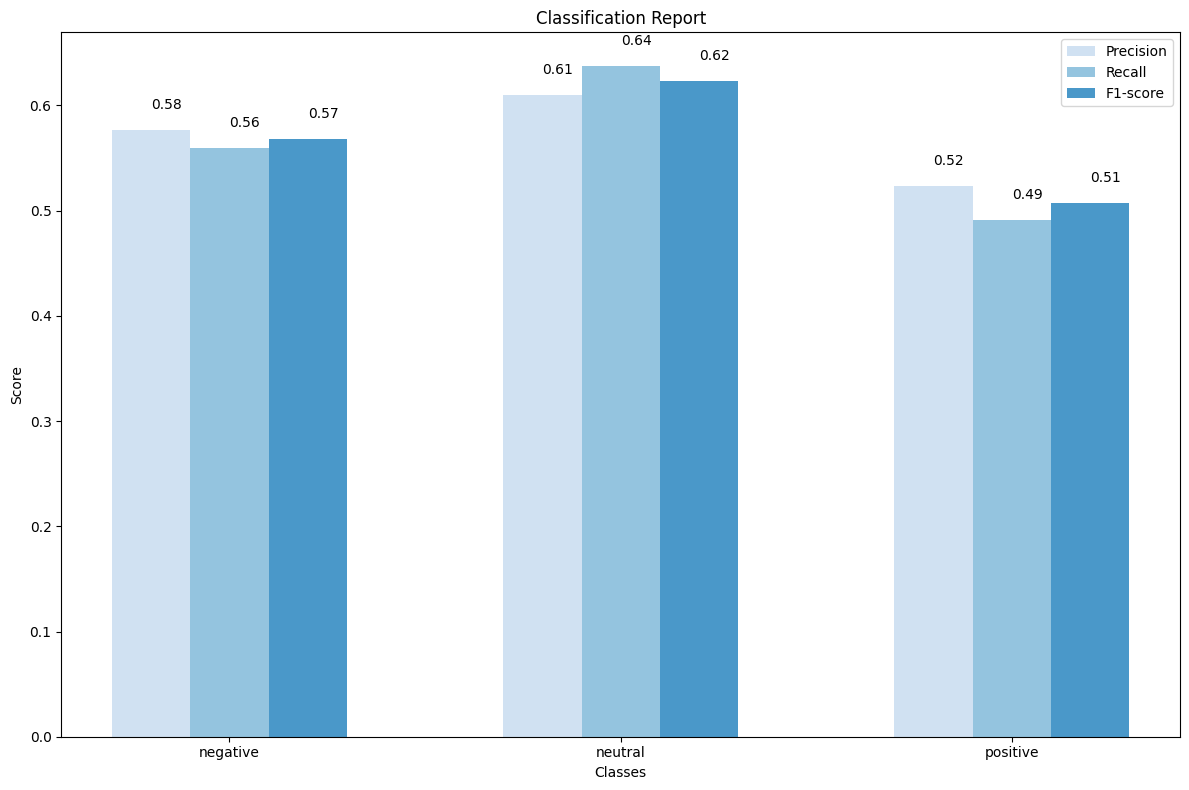

In [76]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report

# Generate classification report
report = classification_report(labels_test, final_pred, target_names=['negative', 'neutral', 'positive'], output_dict=True)

# Extract metrics and classes
metrics = list(report.keys())
classes = list(report.keys())[:-3]

# Extract metric values for each class
precision = [report[c]['precision'] for c in classes]
recall = [report[c]['recall'] for c in classes]
f1_score = [report[c]['f1-score'] for c in classes]
support = [report[c]['support'] for c in classes]

# Create a figure and axes
fig, ax = plt.subplots(figsize=(12, 8))

# Define color scheme
color_scheme = plt.cm.get_cmap('Blues')

# Plot precision, recall, and F1-score with blue color
x = np.arange(len(classes))
width = 0.2
ax.bar(x - width, precision, width, label='Precision', color=color_scheme(0.2))
ax.bar(x, recall, width, label='Recall', color=color_scheme(0.4))
ax.bar(x + width, f1_score, width, label='F1-score', color=color_scheme(0.6))

# Set labels and title
ax.set_xlabel('Classes')
ax.set_ylabel('Score')
ax.set_title('Classification Report')
ax.set_xticks(x)
ax.set_xticklabels(classes)
ax.legend()

# Add text labels to each bar
for i in range(len(classes)):
    ax.text(i - width, precision[i] + 0.02, f'{precision[i]:.2f}')
    ax.text(i, recall[i] + 0.02, f'{recall[i]:.2f}')
    ax.text(i + width, f1_score[i] + 0.02, f'{f1_score[i]:.2f}')

plt.tight_layout()
plt.show()

In [77]:
cm=confusion_matrix(labels_test,final_pred)
cm

array([[2131, 1389,  291],
       [1322, 3662,  759],
       [ 242,  955, 1155]])

In [78]:
import matplotlib.pyplot as plt
import itertools

In [79]:
def plot_confusion_matrix(cm, classes,
                        normalize=False,
                        title='Confusion matrix',
                        cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="black" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization

[[2131 1389  291]

 [1322 3662  759]

 [ 242  955 1155]]


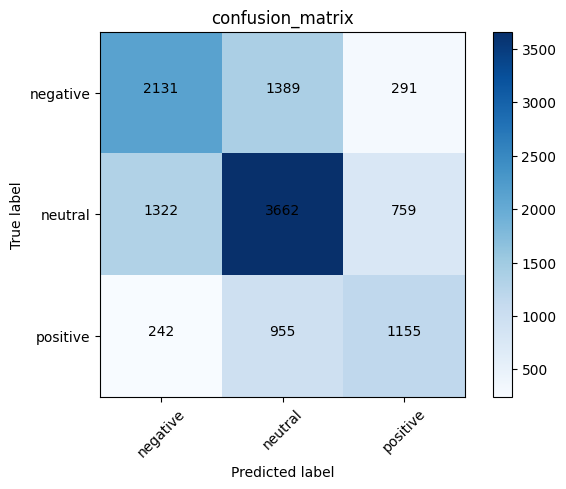

In [80]:
cm_plot_labels = ['negative', 'neutral', 'positive']
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='confusion_matrix')

In [81]:
 from matplotlib import pyplot

In [106]:
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score

In [107]:
all_tweets = clean_training_tweets + clean_testing_tweets

length = len(clean_training_tweets)

In [84]:
cv = CountVectorizer(binary=True, ngram_range = (1,3))
bow= cv.fit_transform(all_tweets)
bow_train = bow[:length]
bow_test = bow[length:]

In [86]:
model = MultinomialNB(alpha= 1.0).fit(bow_train, labels)
label_pred = model.predict(bow_test)

In [87]:
print("Classification Report for Naive Bayes")
print(confusion_matrix(labels_test,label_pred))
print(classification_report(labels_test,label_pred))
print(accuracy_score(labels_test, label_pred))

Classification Report for Naive Bayes

[[2791  729  291]

 [2413 2207 1123]

 [ 406  515 1431]]

              precision    recall  f1-score   support



           0       0.50      0.73      0.59      3811

           1       0.64      0.38      0.48      5743

           2       0.50      0.61      0.55      2352



    accuracy                           0.54     11906

   macro avg       0.55      0.58      0.54     11906

weighted avg       0.57      0.54      0.53     11906



0.539979842096422


Confusion matrix, without normalization

[[2791  729  291]

 [2413 2207 1123]

 [ 406  515 1431]]


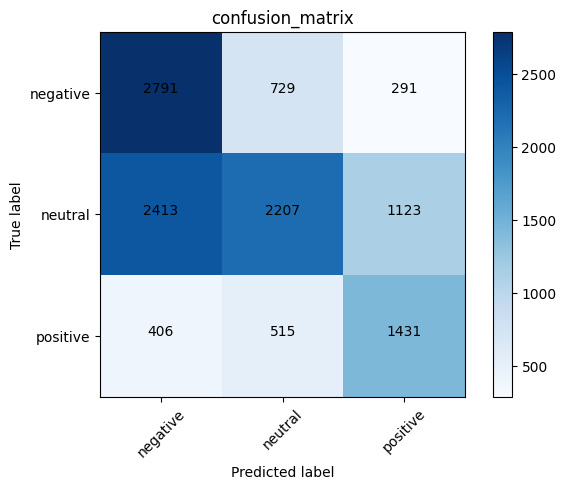

In [88]:
cm_plot_labels = ['negative', 'neutral', 'positive']
plot_confusion_matrix(cm=confusion_matrix(labels_test,label_pred), classes=cm_plot_labels, title='confusion_matrix')

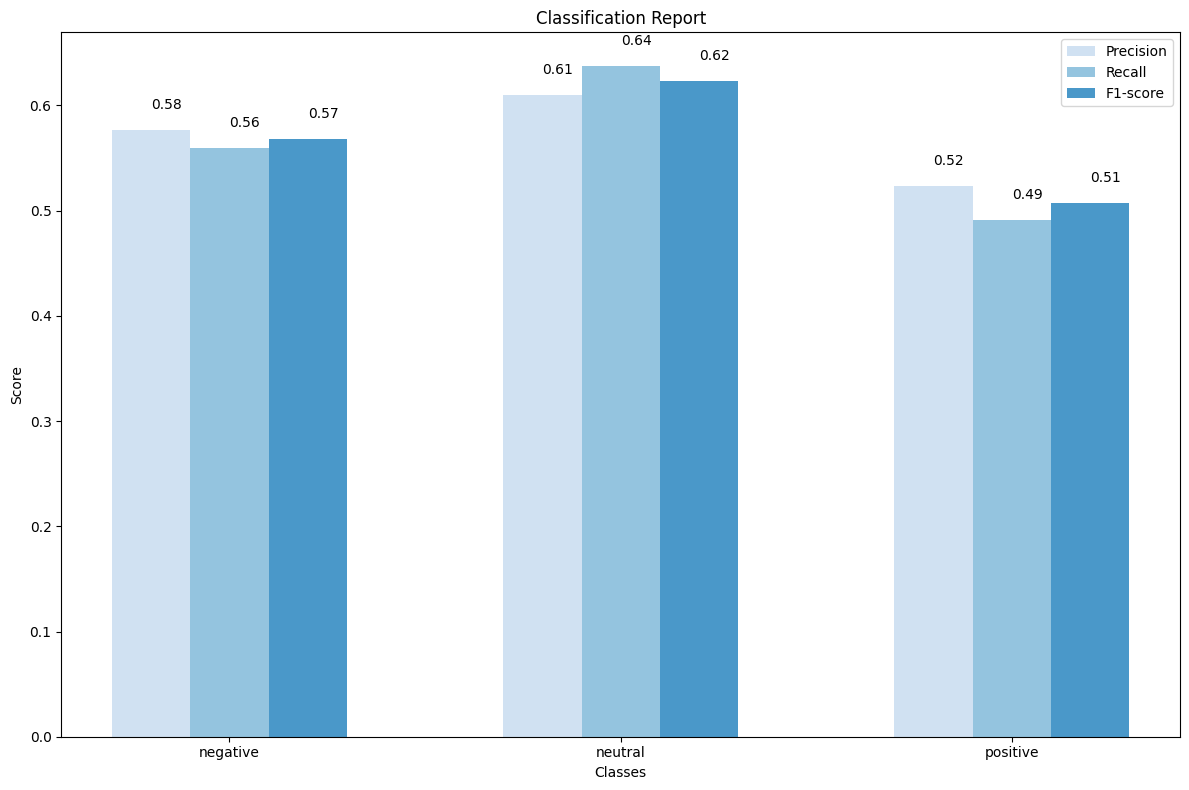

In [89]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report

# Generate classification report
report = classification_report(labels_test, final_pred, target_names=['negative', 'neutral', 'positive'], output_dict=True)

# Extract metrics and classes
metrics = list(report.keys())
classes = list(report.keys())[:-3]

# Extract metric values for each class
precision = [report[c]['precision'] for c in classes]
recall = [report[c]['recall'] for c in classes]
f1_score = [report[c]['f1-score'] for c in classes]
support = [report[c]['support'] for c in classes]

# Create a figure and axes
fig, ax = plt.subplots(figsize=(12, 8))

# Define color scheme
color_scheme = plt.cm.get_cmap('Blues')

# Plot precision, recall, and F1-score with blue color
x = np.arange(len(classes))
width = 0.2
ax.bar(x - width, precision, width, label='Precision', color=color_scheme(0.2))
ax.bar(x, recall, width, label='Recall', color=color_scheme(0.4))
ax.bar(x + width, f1_score, width, label='F1-score', color=color_scheme(0.6))

# Set labels and title
ax.set_xlabel('Classes')
ax.set_ylabel('Score')
ax.set_title('Classification Report')
ax.set_xticks(x)
ax.set_xticklabels(classes)
ax.legend()

# Add text labels to each bar
for i in range(len(classes)):
    ax.text(i - width, precision[i] + 0.02, f'{precision[i]:.2f}')
    ax.text(i, recall[i] + 0.02, f'{recall[i]:.2f}')
    ax.text(i + width, f1_score[i] + 0.02, f'{f1_score[i]:.2f}')

plt.tight_layout()
plt.show()

In [109]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [112]:
tf_vec= TfidfVectorizer()
tf_vec_all= tf_vec.fit_transform(all_tweets)
tf_vec_train= bow[:length]
tf_vec_test= bow[length:]

In [113]:
model = MultinomialNB(alpha= 1.0).fit(tf_vec_train, labels)
label_pred = model.predict(tf_vec_test)

In [114]:
print("Classification Report for Naive Bayes")
print(confusion_matrix(labels_test,label_pred))
print(classification_report(labels_test,label_pred))
print(accuracy_score(labels_test, label_pred))

Classification Report for Naive Bayes

[[ 171 3231  409]

 [  46 4750  947]

 [   2 1022 1328]]

              precision    recall  f1-score   support



           0       0.78      0.04      0.08      3811

           1       0.53      0.83      0.64      5743

           2       0.49      0.56      0.53      2352



    accuracy                           0.52     11906

   macro avg       0.60      0.48      0.42     11906

weighted avg       0.60      0.52      0.44     11906



0.524861414412901


Confusion matrix, without normalization

[[ 171 3231  409]

 [  46 4750  947]

 [   2 1022 1328]]


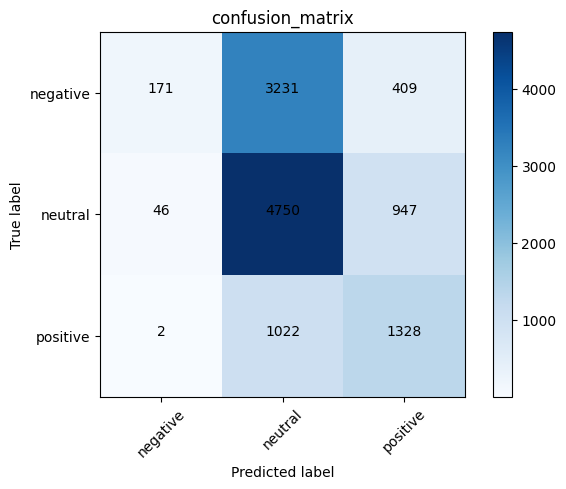

In [115]:
cm_plot_labels = ['negative', 'neutral', 'positive']
plot_confusion_matrix(cm=confusion_matrix(labels_test,label_pred), classes=cm_plot_labels, title='confusion_matrix')

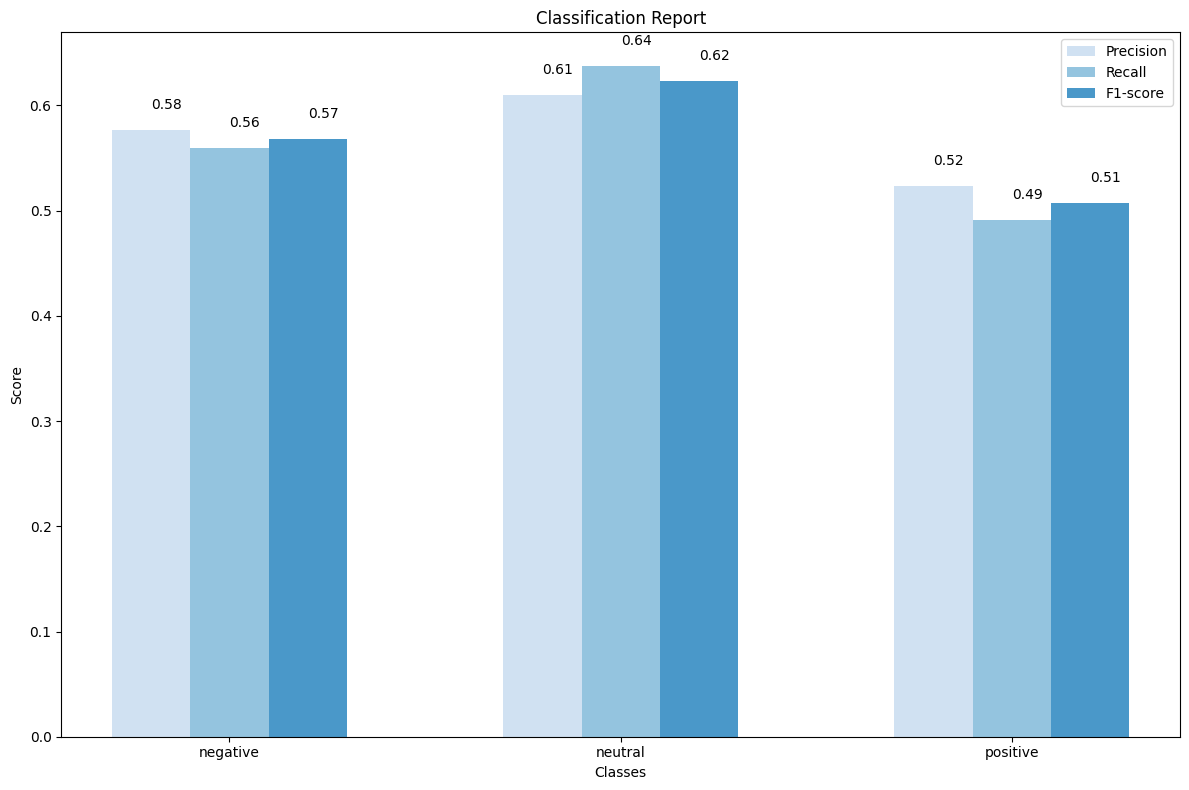

In [116]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report

# Generate classification report
report = classification_report(labels_test, final_pred, target_names=['negative', 'neutral', 'positive'], output_dict=True)

# Extract metrics and classes
metrics = list(report.keys())
classes = list(report.keys())[:-3]

# Extract metric values for each class
precision = [report[c]['precision'] for c in classes]
recall = [report[c]['recall'] for c in classes]
f1_score = [report[c]['f1-score'] for c in classes]
support = [report[c]['support'] for c in classes]

# Create a figure and axes
fig, ax = plt.subplots(figsize=(12, 8))

# Define color scheme
color_scheme = plt.cm.get_cmap('Blues')

# Plot precision, recall, and F1-score with blue color
x = np.arange(len(classes))
width = 0.2
ax.bar(x - width, precision, width, label='Precision', color=color_scheme(0.2))
ax.bar(x, recall, width, label='Recall', color=color_scheme(0.4))
ax.bar(x + width, f1_score, width, label='F1-score', color=color_scheme(0.6))

# Set labels and title
ax.set_xlabel('Classes')
ax.set_ylabel('Score')
ax.set_title('Classification Report')
ax.set_xticks(x)
ax.set_xticklabels(classes)
ax.legend()

# Add text labels to each bar
for i in range(len(classes)):
    ax.text(i - width, precision[i] + 0.02, f'{precision[i]:.2f}')
    ax.text(i, recall[i] + 0.02, f'{recall[i]:.2f}')
    ax.text(i + width, f1_score[i] + 0.02, f'{f1_score[i]:.2f}')

plt.tight_layout()
plt.show()